# Politweet, summarizing political debates through Twitter

The scope of this project is to build a tool that can summarize a political debate, taking into account what aspects of the debate people liked and understanding the bipolarity of the twittersphere.

The following is an example of the dataset provided.

In [224]:
%matplotlib inline
import re
import pandas as pd
pd.set_option('display.max_colwidth', 1200)
import numpy as np
from IPython.display import display
import nltk
from __future__ import unicode_literals
from spacy.en import English
nlp = English()

In [225]:
# Retrieving the tweets from a file
def get_tweets(filename):
    df = pd.read_csv(filename, sep='\t', encoding='utf-8', index_col="tweet.id")
    return df

df = get_tweets("./debate08_sentiment_tweets.tsv")
df[:1]

,pub.date.GMT,content,author.name,author.nickname,rating.1,rating.2,rating.3,rating.4,rating.5,rating.6,rating.7,rating.8
tweet.id,,,,,,,,,,,,
936469851,9/27/08 1:01,Watching by myself #tweetdebate Not drinking :( waiting to start cringing at McCains blunders,drgilpin,Dawn Gilpin,1,1,4,NaN,NaN,NaN,NaN,NaN


In [212]:
# Function to nicely print out the tweets
def list_content(df):
    for i, row in enumerate(zip(df["author.name"].values, df["content"].values)):
        print i, row

list_content(df[:3])

0 (u'drgilpin', u'Watching by myself  #tweetdebate Not drinking :( waiting to start cringing at McCains blunders')
1 (u'starweaver', u"@ahg3 @MichDot Yeah, slime was actually my second choice, can't say what the first one was. Okay, we're rolling...")
2 (u'kyeung808', u'Preparing to have a heart attack #tweetdebate')


## Pre-processing

Before starting building our tools, we aimed at cleaning the data and pre-process it. For example, we perform sentence and word tokenization and we normalize all the mentions to McCain and Obama. There are cases in which McCain is mispelled

In [234]:
# We apply this function to pre-process the data
# This cleans error and tokenize the tweets into word tokens
def pre_processing(df):
    df["content"] = df["content"].apply(lambda x: re.sub(r'MCCAINs?', 'McCain', x, flags=re.IGNORECASE))
    df["content"] = df["content"].apply(lambda x: re.sub(r'Obama|Barack', 'Obama', x, flags=re.IGNORECASE))
    df["tokens"] = df["content"].apply(lambda x: nltk.tokenize.word_tokenize(x))
    return df

df = pre_processing(df)
print "Example of word tokens"
df[["tokens"]][:1]

Example of word tokens


,tokens
tweet.id,
936469851,"[Watching, by, myself, #, tweetdebate, Not, drinking, :, (, waiting, to, start, cringing, at, McCain, blunders]"


## Sentiment

Our first step is build a sentiment analysis classifier. We will use this to understand whether users are expressing positive or negative sentiment towards a topic and a candidate. In addition, we aim at improving the scores given by Amazon Mechanical Turks, which do not grade the tweets with this depth of details. However, we use the AMT ratings only when all the ratings are equal. We use this our label for our training set.

### Approaches
Our approaches for sentiment analysis will be the following:

1. Rule-based system
2. Using a lexicon
3. Machine learning techniques

Our assumption is that given the specificity of the topic, open-domain machine learning techniques for sentiment analysis, such as Socher 2014 (Recursive Neural Networks) would not satisfy our needs in this particular case, since we may want to train the network with data that are more precise to our problem, however our dataset is too small to do such test. Hence, we attempt at using existing lexicons such as SentiWordnet.

After our exporatory data analysis stage, we found that there are very simple rules that we can understand from the different tweets. For example, "-3 Obama" is a notation that is used in the tweets to specify that the user disagree with something Obama has said, hence we can can collect rules of this kind and build a rule-based system for sentiment analysis. In addition, we plan to use the outcome of the different rules into a classifier and learn their weights.

The following code consists in helping function to retrieve all the tweets that contains *some* ratings of the same kind and *all* ratings of the same kind.

In [214]:
rating = {1:"negative", 2:"positive", 3:"mixed", 4:"other" }

# This static class will help us to filter for Rating.NEGATIVE, etc.
class Rating:
    NEGATIVE = 1
    POSITIVE = 2
    MIXED = 3
    OTHER = 4

# At least one of thar rating
def some_rating(df, rating):
    return df[
        (df["rating.1"]==rating) |
        (df["rating.2"]==rating) |
        (df["rating.3"]==rating) |
        (df["rating.4"]==rating) |
        (df["rating.5"]==rating) |
        (df["rating.6"]==rating) |
        (df["rating.7"]==rating) |
        (df["rating.8"]==rating)
    ]

# Everyone with the same rating
def all_rating(df, rating):
    return df[
        ((df["rating.1"]==rating) | (df["rating.1"] != df["rating.1"])) &
        ((df["rating.2"]==rating) | (df["rating.2"] != df["rating.2"])) &
        ((df["rating.3"]==rating) | (df["rating.3"] != df["rating.3"])) &
        ((df["rating.4"]==rating) | (df["rating.4"] != df["rating.4"])) &
        ((df["rating.5"]==rating) | (df["rating.5"] != df["rating.5"])) &
        ((df["rating.6"]==rating) | (df["rating.6"] != df["rating.6"])) &
        ((df["rating.7"]==rating) | (df["rating.7"] != df["rating.7"])) &
        ((df["rating.8"]==rating) | (df["rating.8"] != df["rating.8"]))
    ]

In [252]:
some_negative = some_rating(df, Rating.NEGATIVE)
all_negative = all_rating(df, Rating.NEGATIVE)

some_positive = some_rating(df, Rating.POSITIVE)
all_positive = all_rating(df, Rating.POSITIVE)

print "At least one negative"
display(some_negative[:2][["content", "rating.1", "rating.2", "rating.3"]])
print "All negative"
display(all_negative[:2][["content", "rating.1", "rating.2", "rating.3"]])
print "All positive"
display(all_positive[:2][["content", "rating.1", "rating.2", "rating.3"]])

At least one negative


,content,rating.1,rating.2,rating.3
tweet.id,,,,
936469851,Watching by myself #tweetdebate Not drinking :( waiting to start cringing at McCain blunders,1,1,4
936470432,"@ahg3 @MichDot Yeah, slime was actually my second choice, can't say what the first one was. Okay, we're rolling...",1,1,1


All negative


,content,rating.1,rating.2,rating.3
tweet.id,,,,
936470432,"@ahg3 @MichDot Yeah, slime was actually my second choice, can't say what the first one was. Okay, we're rolling...",1,1,1
936472030,Preparing to have a heart attack #tweetdebate,1,1,1


All positive


,content,rating.1,rating.2,rating.3
tweet.id,,,,
936469906,Current TV is pretty cool. Streaming Twitter feedback #tweetdebate,2,2,2
936470049,#tweetdebate - good luck both candidates,2,2,2


### Exploring the polarity rule-based

At this stage, we decided to explore whether we can find a simple matching rule to define the polarity ...Showing tweets that have -1, -2, -3.. in the text, in order to write a rule-based system

In [241]:
# Extract all the tweets with -
def minus_df(df):
    return df[df["content"].str.contains("\-[0-9]+")]

# Extract all the tweets with +
def plus_df(df):
    return df[df["content"].str.contains("\+[0-9]+")]

minus_rule = minus_df(all_negative)
plus_rule = plus_df(all_positive)

print "Negative tweets with -"
list_content(minus_rule[:3])
print "\nPositive tweets with -"
list_content(plus_rule[:3])

print "\nThere are in total " + str( len (minus_rule + plus_rule) ) + " matched documents"

Negative tweets with -
0 (u'themurmish', u'McCain just gave a cheap plug to Ed Kennedy -1 #tweetdebate #current')
1 (u'dabloguiman', u'McCain -2 for not knowing Kennedy is home and watching the debate  #tweetdebate')
2 (u'ferret67', u'McCain is talking about bipartisan negotiation? Uh...no... -1 pt. #tweetdebate #current')

Positive tweets with -
0 (u'naum', u'Obama +1 for swift and wise  #tweetdebate')
1 (u'nohype', u'+1 for Obama "Moving fast, moving swiftly" #tweetdebate')
2 (u'fritzpw', u'" Obama +1 for articulating his plans - initial & recognition #tweetdebate"')

There are in total 258 matched documents


### Exploring a naive bayes classifier

We decided to use our rules as a features into a Naive Bayes Classifier.

Hence we write two regular expressions to match + and - tweets, previously filtered by same-rating by ATM

In [242]:
# regular expressions to match - and +
plus_regex = re.compile(".*(\+[0-9]+).*")
minus_regex = re.compile(".*(\-[0-9]+).*")

In [243]:
# Extract features of a document
def document_features(document):
    document_words = set(document["tokens"])
    document_words_l = (d.lower() for d in set(document["tokens"]))
    features = {}
    # Positive/Negative polarity if contains a +/-
    features['polarity(+)'] = plus_regex.match(document["content"]) != None
    features['polarity(-)'] = minus_regex.match(document["content"]) != None
    # Point out that contains the word Obama/McCain
    features['contains(obama)'] = "obama" in document_words_l
    features['contains(mccain)'] = "mccain" in document_words_l
    return features

In order to train the classifier, we decided to split the two datasets 80% training, 20% test

In [245]:
# splits the data in train, dev using the factor
def split_dataset(dataset, factor):
    limit = int(len(dataset)*factor)
    return dataset[:limit], dataset[limit:]

#  label each document with `pos` or `neg` if contain the rule
pos = [(document_features(d), "pos") for i, d in plus_rule.iterrows()]
neg = [(document_features(d), "neg") for i, d in minus_rule.iterrows()]

# split the datasets
pos_train, pos_test = split_dataset(pos, 0.8)
neg_train, neg_test = split_dataset(neg, 0.8)
# join the train and the test
train_set = pos_train + neg_train
test_set = pos_train + neg_train

The following result shows a really great outcome of our very simple classifier. 100% of the tweets are marked correctly

In [247]:
# run the classifier
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))
classifier.show_most_informative_features(5)

1.0
Most Informative Features
         contains(obama) = False             neg : pos    =      3.2 : 1.0
         contains(obama) = True              pos : neg    =      3.0 : 1.0
        contains(mccain) = True              neg : pos    =      1.4 : 1.0
        contains(mccain) = False             pos : neg    =      1.0 : 1.0


In [248]:
# Use this an example to test your sentence
for_example = "Obama was crap +1"
for_example_tokens = nltk.tokenize.word_tokenize(for_example)
for_example_doc = dict(tokens=for_example_tokens, content=for_example)
classifier.classify(document_features(for_example_doc))

u'pos'

How does this classifier performs on tweets that are not marked with the same score by ATM?

In [249]:
# This does the set minus operations over the tweet ids
def df_setminus(d1, d2):
    index = d1.index.difference(d2.index)
    return d1.reindex(index)

# Getting the tweet that have not marked all in the same way
# but contain at least one positive for disagreeing positive
# and one negative, for disagreeing negative
disagreeing_positive = df_setminus(some_positive, all_positive)
disagreeing_negative = df_setminus(some_negative, all_negative)

# We further filter them with the minus and the plus rule
minus_rule_disagreeing = minus_df(disagreeing_positive)
plus_rule_disagreeing = plus_df(disagreeing_negative)

print len(minus_rule_disagreeing)
display(minus_rule_disagreeing[:1])
print len(plus_rule_disagreeing)
display(plus_rule_disagreeing[:1])

63


,pub.date.GMT,content,author.name,author.nickname,rating.1,rating.2,rating.3,rating.4,rating.5,rating.6,rating.7,rating.8,tokens
tweet.id,,,,,,,,,,,,,
936479038,9/27/08 1:07,-1 McCain for stalling with faux sympathy #tweetdebate,KennyL,Kenny Lauer,1,2,1,NaN,NaN,NaN,NaN,NaN,"[-1, McCain, for, stalling, with, faux, sympathy, #, tweetdebate]"


64


,pub.date.GMT,content,author.name,author.nickname,rating.1,rating.2,rating.3,rating.4,rating.5,rating.6,rating.7,rating.8,tokens
tweet.id,,,,,,,,,,,,,
936479026,9/27/08 1:07,McCain +1 for plugging Kennedy #tweetdebate,gminks,Gina Minks,1,2,2,2,NaN,NaN,NaN,NaN,"[McCain, +1, for, plugging, Kennedy, #, tweetdebate]"


# Topic modeling


Here we attempt exploratory topic modelling, starting from understanding how hashtags are used.
However, how we can see from the following examples, hashtags haven't been used to point out the topic discussed. Only three tweets contain hashtags different from #tweetdebate, #current, #debate, #debate08. Hence, the results are trivial for further analysis

In [250]:
# we get all the tweets that do not contain
# the hashtags #tweetdebate, #current, #debate
# but that still contain a hashtag

with_hashtags = df[
    (df["content"].str.contains("#"))
    & (~df["content"].str.contains("#tweetdebate|current|debate", flags=re.IGNORECASE))
]
with_hashtags

,pub.date.GMT,content,author.name,author.nickname,rating.1,rating.2,rating.3,rating.4,rating.5,rating.6,rating.7,rating.8,tokens
tweet.id,,,,,,,,,,,,,
936509930,9/27/08 1:22,@davidweiner You're playing that game? I'm drinking everytime I hear #economy.,SukiFuller,Suki Fuller,1,1,2,NaN,NaN,NaN,NaN,NaN,"[@, davidweiner, You, 're, playing, that, game, ?, I, 'm, drinking, everytime, I, hear, #, economy, .]"
936722330,9/27/08 3:17,"@seasonothebitch same here, actually -- I am feeling a bit of pain after all those #McCainhots (water is helping)",beretta627,Chris,2,1,1,NaN,NaN,NaN,NaN,NaN,"[@, seasonothebitch, same, here, ,, actually, --, I, am, feeling, a, bit, of, pain, after, all, those, #, McCainhots, (, water, is, helping, )]"
936646130,9/27/08 2:26,"@cgritter #Obamashot when Obama says ""Change"". #McCainhot when he says ""my friends""",CarriBugbee,Carri Bugbee,1,4,4,NaN,NaN,NaN,NaN,NaN,"[@, cgritter, #, Obamashot, when, Obama, says, ``, Change, '', ., #, McCainhot, when, he, says, ``, my, friends, '']"


# Clustering

The following graph shows the distribution of tweets per user.

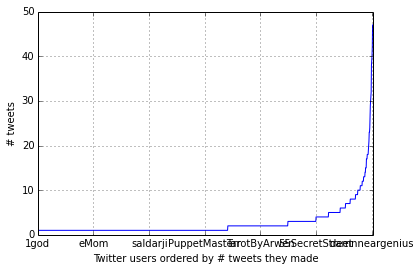

In [251]:
ax = df.groupby("author.name").size().order().plot()
ax.set_xlabel("Twitter users ordered by # tweets they made")
ax.set_ylabel("# tweets")